!pip install -U gym gym[other] tensorflow keras autorom gym[accept-rom-license] gym[atari] torch

In [1]:
import numpy as np
from collections import deque
import gym
import random

In [2]:
env = gym.make("Breakout-v4", obs_type='grayscale', render_mode='rgb_array', full_action_space=False, frameskip=4)
env = gym.wrappers.AtariPreprocessing(env=env, frame_skip=1, terminal_on_life_loss=True)
env = gym.wrappers.FrameStack(env=env, num_stack=4)
# env = gym.wrappers.RecordVideo(env, 'videos', episode_trigger= lambda x : x % 30 == 0)


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/home/meliioko/dqn-breakout/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(


In [3]:
state = env.reset()
state

/home/meliioko/dqn-breakout/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(<gym.wrappers.frame_stack.LazyFrames at 0x7f70387e6d40>,
 {'lives': 5, 'episode_frame_number': 36, 'frame_number': 36})

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class DQN(nn.Module):
    def __init__(self, action_size):
        super(DQN, self).__init__()

        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)  # Assuming input_shape is (channels, height, width)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Compute the size of the output of the last conv layer
        def conv2d_size_out(size, kernel_size=3, stride=1):
            return (size - (kernel_size - 1) - 1) // stride + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(84, 8, 4), 4, 2), 3, 1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(84, 8, 4), 4, 2), 3, 1)
        linear_input_size = convw * convh * 64

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linear_input_size, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )


    def forward(self, x):

        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))

        return self.fc(x)

def update_target_network(target, source):
    target.load_state_dict(source.state_dict())


In [5]:
import copy
# Set parameters
N = 40000  # Replay memory capacity
M = 10_000_000  # Number of episodes
T = 10000  # Max steps per episode
C = 40  # Target network update frequency
epsilon = 1
epsilon_decay = 0.99
epsilon_min = 0.1
gamma = 0.99
action_size = env.action_space.n  # Number of actions
state_size = env.observation_space.shape[0]  # State size

# Initialize replay memory


Q = DQN(action_size)
Q_hat = copy.deepcopy(Q)
D = deque(maxlen=N)


# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Q.to(device)
Q_hat.to(device)
optimizer = optim.Adam(Q.parameters(), lr=0.0025)
criterion = nn.MSELoss()



# Convert numpy array to PyTorch tensor
def preprocess_state(state):
  return torch.tensor(np.asarray(state)).float().div(255).unsqueeze(0).to(device)  # Scales to [0,1]

frames = 0
reward_list = []
loss_list = []
episode = 0

Using GPU: NVIDIA GeForce RTX 2060


In [6]:
from tqdm import tqdm
optimizer = optim.Adam(Q.parameters(), lr=0.00025)

# Training loop
pbar = tqdm(total=M)
while(frames < M):
    total_reward = 0
    state = preprocess_state(env.reset()[0])# Add batch dimension
    for t in range(T):
        # Epsilon-greedy action selection
        if T < 30000:
            action = random.randrange(action_size)
        elif np.random.rand() <= epsilon:
            action = random.randrange(action_size)
        else:
            with torch.no_grad():  # No need to track gradients here
                act_values = Q(state)
                action = act_values.max(1)[1].item()  # Choose the action with the highest Q-value

        # Execute action in environment and observe next state and reward
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        frames += 1
        pbar.update(1)


        next_state = preprocess_state(next_state)

        # Store transition in D (experience replay buffer)
        D.append((state, action, reward, next_state, done))
        d_len = len(D)

        state = next_state

        # Check if the episode is done
        if done :
            episode += 1
            # if episode % 20 == 0:
            #   print(f"Episode: {episode}, Score: {total_reward}, Nb_frames : {frames}")
            reward_list.append(total_reward)
            break



        # Train using a random minibatch from D
        if len(D) > 30000:
            minibatch = random.sample(D, 32)
            # Extract tensors from the minibatch
            states = torch.cat([s for s, a, r, ns, d in minibatch]).to(device)
            actions = torch.tensor([a for s, a, r, ns, d in minibatch], device=device).long()
            rewards = torch.tensor([r for s, a, r, ns, d in minibatch], device=device).float()
            next_states = torch.cat([ns for s, a, r, ns, d in minibatch]).to(device)
            dones = torch.tensor([d for s, a, r, ns, d in minibatch], device=device).float()


            # Compute Q values for current states
            Q_values = Q(states)
            # Select the Q value for the action taken, which are the ones we want to update
            Q_values = Q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

            # Compute the Q values for next states using the target network
            with torch.no_grad():
                next_state_values = Q_hat(next_states).max(1)[0]
                # If done is true, we want to ignore the next state value
                next_state_values[dones == 1] = 0.0
                # Compute the target Q values
                target_Q_values = rewards + (gamma * next_state_values)

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Compute loss
            loss = criterion(Q_values, target_Q_values)
            # Backward pass
            loss.backward()
            loss_list.append(loss.item())
            torch.nn.utils.clip_grad_norm_(Q.parameters(), max_norm=1.0)
            optimizer.step()

    # Update epsilon
    if epsilon > epsilon_min and T > 30000:
        epsilon *= epsilon_decay

    # Update target network
    if episode % C == 0 and T > 30000:
        Q_hat.load_state_dict(Q.state_dict())

    if episode % 100 == 0 and T > 30000:
        torch.save(Q.state_dict(), 'Q.pt')

pbar.close()

  4%|▎         | 361937/10000000 [36:34<20:06:55, 133.09it/s]

KeyboardInterrupt: 

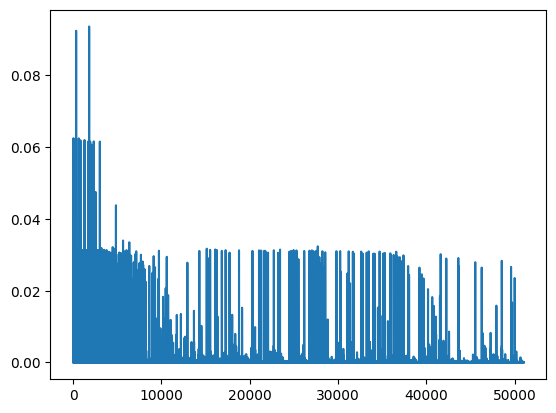

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_list)

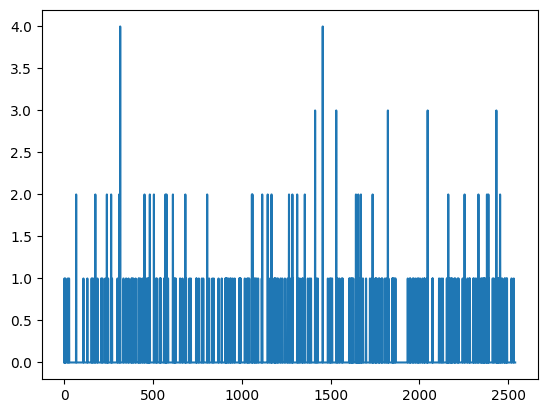

In [ ]:
plt.plot(reward_list)

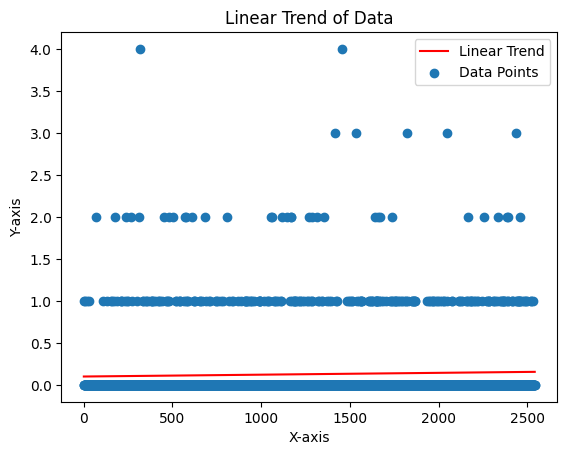

In [ ]:
# Fit the linear model
x = np.arange(1, len(reward_list) + 1)
y = reward_list
coefficients = np.polyfit(x, y, 1)  # 1 means linear
polynomial = np.poly1d(coefficients)

# Generate a number of points for the x-axis (from min to max of your original x)
x_trend = np.linspace(x.min(), x.max(), 100)
# Predict the y values
y_trend = polynomial(x_trend)

# Plot the linear trend
plt.plot(x_trend, y_trend, label='Linear Trend', color='red')

# Optionally, if you want to plot the original data points:
plt.scatter(x, y, label='Data Points')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Linear Trend of Data')
plt.legend()
plt.show()

state = preprocess_state(env.reset()[0])# Add batch dimension
total_reward = 0
q_values = []
while(True):
  with torch.no_grad():  # No need to track gradients here
    act_values = Q(state)
    action = act_values.max(1)[1].item()  # Choose the action with the highest Q-value
    q_values.append(act_values.to('cpu').numpy())
    next_state, reward, done, _, _ = env.step(action)
    total_reward += reward
    if done:
      break
    state = preprocess_state(next_state)
print(total_reward)